# Accuracy Analysis

Note that all the codes were run on 2 core hyper threaded machine. Tha's why time taken starts to crawl upwards after 4 cores.

In [1]:
%matplotlib inline
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
import timeit
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
import scipy as sp

Let's see how our solution looks like for a single case, nprocs=4, no.of samples = 2^12 equally spaced. Calculated solution is plotted in red and the true soltuion is in blue. You can see that these both are 
pretty muhc close.

In [20]:
file = open("results.csv", "w")
tr = %timeit -n 1 -r 1 -o w = p = subprocess.run( ['/usr/bin/mpirun','-n', str(4), './integral','-p',str(10)],stdout=file)
file.close()
A = np.genfromtxt('results.csv', delimiter=',')

#A, time = generate_solution(16, 10)
x = A[:,0]
u = A[:,1]
plt.plot(x,u,'r.')
plt.plot(x,np.sin(2*np.pi*x),'b-')

109 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Let's define a function which can execute out problem3b executable for any number of procs and any number of trapezoids.

In [8]:
def nsolutions(nprocs, pv):
    file = open("results.csv", "w")
    subprocess.run( ['/usr/bin/mpirun','-n', str(nprocs), './integral','-p',str(pv)],stdout=file)
    file.close()
    return np.genfromtxt('results.csv', delimiter=',')

Text(0,0.5,'Error')

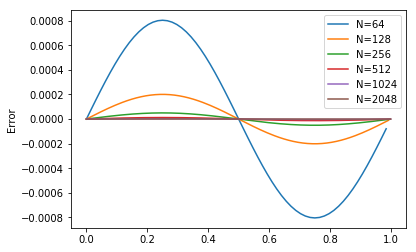

In [17]:
for i in range(6,12):
    N = 2**i
    A = nsolutions(4, i) ##4 procs and i is the power of 2.
    x = A[:,0]
    u = A[:,1]
    plt.plot(x,u-np.sin(2*np.pi*x), label='N='+str(N))
plt.legend()
plt.ylabel('Error')

You can see that as number of samples increases the error goes to 0 indicating that the solution is converging to the true soltuion.

# Scaling Analysis

In [24]:
%%capture
data = {}
columns = ['Processors', 'Time Taken', 'Error']

for nprocs in [1, 2, 4, 8]:
    df = pd.DataFrame(columns=columns)
    for pv in range(6, 12):
        file = open("results.csv", "w")
        tr = %timeit -n 1 -r 1 -o p = subprocess.run(['/usr/bin/mpirun','-n', str(nprocs), './integral','-p',str(pv)],stdout=file)
        file.close()
        A = np.genfromtxt('results.csv', delimiter=',')
        x = A[:,0]
        u = A[:,1]
        error = np.linalg.norm(u - np.sin(2*np.pi*x))
        data_row = {'Processors': nprocs, 'Time Taken': tr.best, 'Error':error}
        df = df.append(pd.Series(data=data_row, name=2**pv))
    data['p' + '{:02d}'.format(nprocs) ] = df
panel = pd.Panel(data)

## Strong Scaling

Text(0,0.5,'Time Taken')

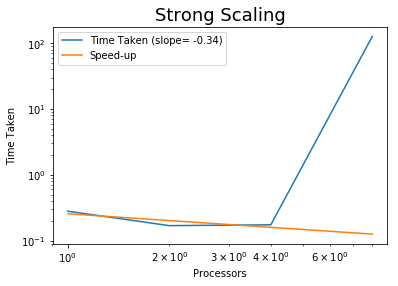

In [31]:
times = np.array(panel.minor_xs('Time Taken'))[-1]
nprocs = [2**i for i in range(len(times))]
#plt.loglog(procs, times, 'bo')
plt.loglog(nprocs, times)

t_strong = times
c = np.polyfit(np.log(nprocs[:-1]),np.log(t_strong[:-1]),1)
plt.semilogx(nprocs,np.exp(np.polyval(c,np.log(nprocs))))

plt.legend(['Time Taken (slope={:6.2f})'.format(c[0]),'Speed-up'])
plt.title('Strong Scaling',fontsize=18);
plt.xlabel('Processors')
plt.ylabel('Time Taken')

## Weak Scaling

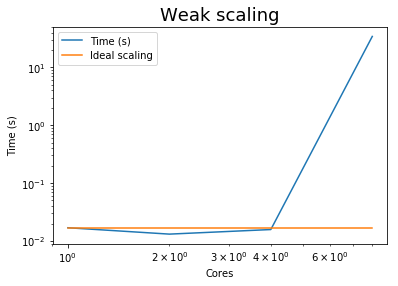

In [32]:
times = np.diag(panel.minor_xs('Time Taken'))
nprocs = [2**i for i in range(len(times))]

plt.loglog(nprocs, times)

t_weak = times

plt.semilogx(nprocs,[t_weak[0] for p in nprocs])

plt.title('Weak scaling', fontsize=18)
plt.xlabel('Cores')
plt.ylabel("Time (s)")
plt.legend(['Time (s)','Ideal scaling'])

## Effeciency Analysis

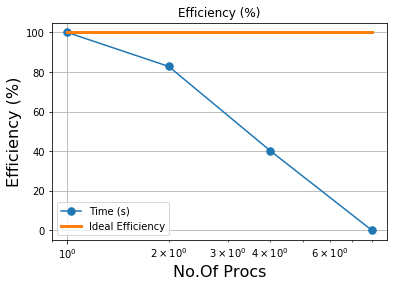

In [36]:
plt.figure()
plt.clf()

# Efficiency
E = t_strong[0]/(nprocs*t_strong)*100

plt.semilogx(procs,E,'.-',markersize=15)
plt.semilogx(procs,[100]*len(procs),linewidth=3)

plt.xlabel('No.Of Procs',fontsize=16)
plt.ylabel('Efficiency (%)',fontsize=16)
plt.title("Efficiency (%)");
plt.legend(['Time (s)', 'Ideal Efficiency'])
#plt.xlim([1/np.sqrt(2), 2**4.5])
#plt.ylim([5,110])
plt.grid()

# Finite difference

For finite difference we're solving a linear equation of the form A.u=u" , here A is a tri-diagonal matrix and u_ is the differential evaluated at x_j points.

The solution, u = inverse(A).u"

make a tri diagonal matrix using:

scipy.sparse.diags(diagonals, offsets)

diagonals : Sequence of arrays containing the matrix diagonals, corresponding to offsets.


    offsets : sequence of int

    Diagonals to set:
    
            k = 0 the main diagonal
            k > 0 the k-th upper diagonal
            k < 0 the k-th lower diagonal




In [2]:
def FD(N):
    A = sp.sparse.diags([[2]*N,[-1]*(N-1),[-1]*(N-1)],[0,1,-1])
    h = 1/(N+1)
    x_j = [h*i for i in range(1,N+1)]
    x_j =np.array(x_j).reshape(N,1)    ###we have N number of sampling points
    u_ = -(2*np.pi)**2 * np.sin(2*np.pi*x_j)
    u_ *= -h**2
    u = sp.sparse.linalg.spsolve(A.tocsc(),u_)
    return u, np.linalg.norm(u-np.sin(2*np.pi*x_j).ravel())

Number of samples:4096
8.870870729088049e-06


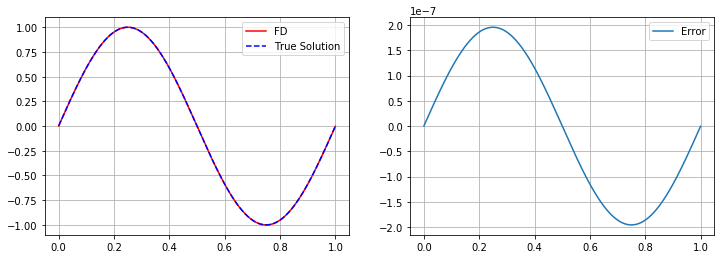

In [5]:
N = 2**12
u, error = FD(N)
print('Number of samples:{}'.format(len(u)))
print(error)
h = 1/(N+1)
x_j = np.array([h*i for i in range(1,N+1)])

fig, ax = plt.subplots(1,2)
fig.set_figwidth(12)

ax[0].plot(x_j,u,'r-')
ax[0].plot(x_j, np.sin(2*np.pi*x_j),'b--')
ax[0].legend(['FD','True Solution'])
ax[0].grid()

ax[1].plot(x_j, u-np.sin(2*np.pi*x_j))
ax[1].legend(['Error'])
ax[1].grid()

## Examining the errors and timing results from Integration and FD methods.

In [18]:
%%capture
Ns = []
fd_times = []
fd_errors = []

int_times = []
int_errors = []

for pv in range(6, 20):
    ### FD method
    N = 2**pv - 1
    Ns += [N]
    tr = %timeit -n 1 -r 1 -o u, error = FD(N)
    u, error = FD(N)
    fd_times += [tr.best]
    fd_errors += [error]
    
for pv in range(6,20):
    ####Integral method
    file = open("results.csv", "w")
    tr = %timeit -n 1 -r 1 -o w = p = subprocess.run(['/usr/bin/mpirun','-n', str(4), './integral','-p',str(pv)], stdout=file)
    file.close()
    A = np.genfromtxt('results.csv', delimiter=',')
    #x = A[:,0]
    #u = A[:,1]
    #error = np.linalg.norm(u - np.sin(2*np.pi*x))
    error = np.linalg.norm(A[:,2])
    int_times += [tr.best]
    int_errors += [error]
    
       

In [19]:
fig, ax = plt.subplots(1,2)
fig.set_figwidth(12)

ax[0].loglog(Ns[:len(int_times)], int_times)
ax[0].loglog(Ns, fd_times)

ax[0].legend(['Integral','Finite Differences(4 cores)'], loc='upper left')
ax[0].set_xlabel('N')
ax[0].set_ylabel('Time (s)')
ax[0].set_title('Runtime vs N')


ax[1].loglog(Ns[:len(int_errors)], int_errors)
ax[1].loglog(Ns, fd_errors)
ax[1].legend(['Integral', 'Finite Differences(4 cores)'], loc='upper left')
ax[1].set_xlabel('N')
ax[1].set_ylabel('Error')
ax[1].set_title('Error vs N')

Text(0.5,1,'Error vs N')

From the plot on the left it's clear that finite difference takes lesser time.
Plot on the right side illustrates the point that error for finite difference 
bottoms out and increases whereas for integral it keeps on decreasing

# Simpson's Rule

In [26]:
file = open("results.csv", "w")
tr = %timeit -n 1 -r 1 -o w = p = subprocess.run( ['/usr/bin/mpirun','-n', str(4), './simpsons','-p',str(12)],stdout=file)
file.close()
A = np.genfromtxt('results.csv', delimiter=',')

#A, time = generate_solution(16, 10)
x = A[:,0]
u = A[:,1]
plt.plot(x,u,'r.')
plt.plot(x,np.sin(2*np.pi*x),'b-')

432 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


# Scaling analysis

In [29]:
%%capture
data = {}
columns = ['Processors', 'Time Taken', 'Error']

for nprocs in [1, 2, 4, 8]:
    df = pd.DataFrame(columns=columns)
    for pv in range(6, 12):
        file = open("results.csv", "w")
        tr = %timeit -n 1 -r 1 -o p = subprocess.run(['/usr/bin/mpirun','-n', str(nprocs), './simpsons','-p',str(pv)],stdout=file)
        file.close()
        A = np.genfromtxt('results.csv', delimiter=',')
        x = A[:,0]
        u = A[:,1]
        error = np.linalg.norm(u - np.sin(2*np.pi*x))
        data_row = {'Processors': nprocs, 'Time Taken': tr.best, 'Error':error}
        df = df.append(pd.Series(data=data_row, name=2**pv))
    data['p' + '{:02d}'.format(nprocs) ] = df
panel = pd.Panel(data)

## Strong Scaling

Text(0,0.5,'Time Taken')

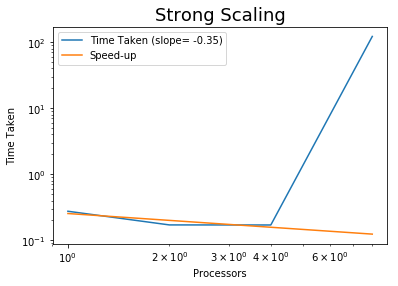

In [32]:
times = np.array(panel.minor_xs('Time Taken'))[-1]
nprocs = [2**i for i in range(len(times))]
plt.loglog(nprocs, times)

t_strong = times
c = np.polyfit(np.log(nprocs[:-1]),np.log(t_strong[:-1]),1)
plt.semilogx(nprocs,np.exp(np.polyval(c,np.log(nprocs))))

plt.legend(['Time Taken (slope={:6.2f})'.format(c[0]),'Speed-up'])
plt.title('Strong Scaling',fontsize=18);
plt.xlabel('Processors')
plt.ylabel('Time Taken')

## Weak Scaling

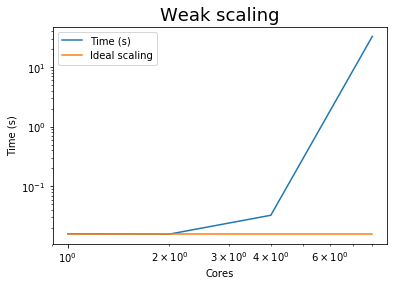

In [34]:
times = np.diag(panel.minor_xs('Time Taken'))
nprocs = [2**i for i in range(len(times))]

plt.loglog(nprocs, times)

t_weak = times

plt.semilogx(nprocs,[t_weak[0] for p in nprocs])

plt.title('Weak scaling', fontsize=18)
plt.xlabel('Cores')
plt.ylabel("Time (s)")
plt.legend(['Time (s)','Ideal scaling'])